# **Классификация степени поражения печени у пациентов**

<div style="border:solid #8A2BE2 2px; padding: 40px">
    
**Cсылка на используемый датасет** [HCV_data](https://archive.ics.uci.edu/ml/datasets/HCV+data)
    
* **X** - идентификационный номер пациента
* **Category** (diagnosis) (values: '0=Blood Donor', '0s=suspect Blood Donor', '1=Hepatitis', '2=Fibrosis', '3=Cirrhosis')
* **Age** - возраст в годах
* **Sex** - пол женский/мужской
* **ALB** - альбумин крови
* **ALP** - щелочная фосфатаза
* **ALT** - аланинтрансаминаза
* **AST** - аспартатаминотрансфераза
* **BIL** - билирубин крови
* **CHE** - холинэстераза
* **CHOL** - холестирин общий
* **CREA** - креатинин
* **GGT** - гамма-глутамилтрансфераза
* **PROT** - протеин

<div style="border:solid #8A2BE2 2px; padding: 40px">

**Цель исследования**
    
Построение модели предсказания класса поражения печени пациентов.

**Ход исследования**

* Загрузка и подготовка данных.
* Создание моделей классификации
* Проверка оптимальности архитектуры моделей

## 1. Обзор данных

In [334]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold

import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
import torch
import torch.nn as nn

from tqdm.notebook import tqdm
from sklearn.metrics import f1_score

In [335]:
data=pd.read_csv('hcvdat0.csv')
display(data.head())
print(data.shape)

,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


(615, 14)


## 2. Предобработка данных

### 2.1 Обзор типов данных

In [336]:
data.info()#общая информация
print(data.isna().sum())# наличие пропусков в данных
print(data.duplicated().sum())# наличие дубликатов в данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  615 non-null    int64  
 1   Category    615 non-null    object 
 2   Age         615 non-null    int64  
 3   Sex         615 non-null    object 
 4   ALB         614 non-null    float64
 5   ALP         597 non-null    float64
 6   ALT         614 non-null    float64
 7   AST         615 non-null    float64
 8   BIL         615 non-null    float64
 9   CHE         615 non-null    float64
 10  CHOL        605 non-null    float64
 11  CREA        615 non-null    float64
 12  GGT         615 non-null    float64
 13  PROT        614 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 67.4+ KB
Unnamed: 0     0
Category       0
Age            0
Sex            0
ALB            1
ALP           18
ALT            1
AST            0
BIL            0
CHE            0
CHOL 

In [337]:
data=data.drop(columns='Unnamed: 0')

Есть несколько категорий с пропусками в данных, но дубликатов не обнаружено. Также видим, что имеется два категориальных признака (один из них целевой), которые нужно закодировать. А также есть лишний столбец, дублирующий значение строки.

### 2.2 Проверка пропусков

In [338]:
display(data[data["ALB"].isna()])
display(data[data["Category"]=="3=Cirrhosis"])

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
603,3=Cirrhosis,65,m,NaN,NaN,40.0,54.0,13.0,7.5,NaN,70.0,107.0,79.0


,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
585,3=Cirrhosis,38,m,44.0,NaN,94.0,60.0,12.0,4.37,3.20,61.0,99.0,77.0
586,3=Cirrhosis,39,m,34.0,137.8,4.8,35.6,9.0,3.65,4.82,519.0,133.4,57.5
587,3=Cirrhosis,41,m,31.0,85.3,4.8,60.2,200.0,1.80,5.34,106.4,151.0,71.8
588,3=Cirrhosis,42,m,36.0,69.6,14.9,263.1,40.0,3.61,3.93,49.6,61.0,68.6
589,3=Cirrhosis,45,m,29.0,11.3,7.1,101.9,31.0,1.73,3.71,76.7,65.6,70.0
590,3=Cirrhosis,46,m,20.0,NaN,62.0,113.0,254.0,1.48,NaN,114.0,138.0,NaN
591,3=Cirrhosis,46,m,35.0,109.6,2.3,19.2,11.0,7.10,4.10,1079.1,105.6,69.1
592,3=Cirrhosis,47,m,42.0,NaN,159.0,102.0,11.0,6.29,5.50,58.0,201.0,79.0
593,3=Cirrhosis,51,m,39.0,66.0,29.6,185.0,19.0,2.00,3.60,58.3,399.5,79.4
594,3=Cirrhosis,51,m,33.0,29.6,4.5,66.6,91.0,4.02,4.08,75.9,28.5,62.3


В данных с классом 3 много пропусков, однако удалять их нельзя, т.к. самих данных очень мало.

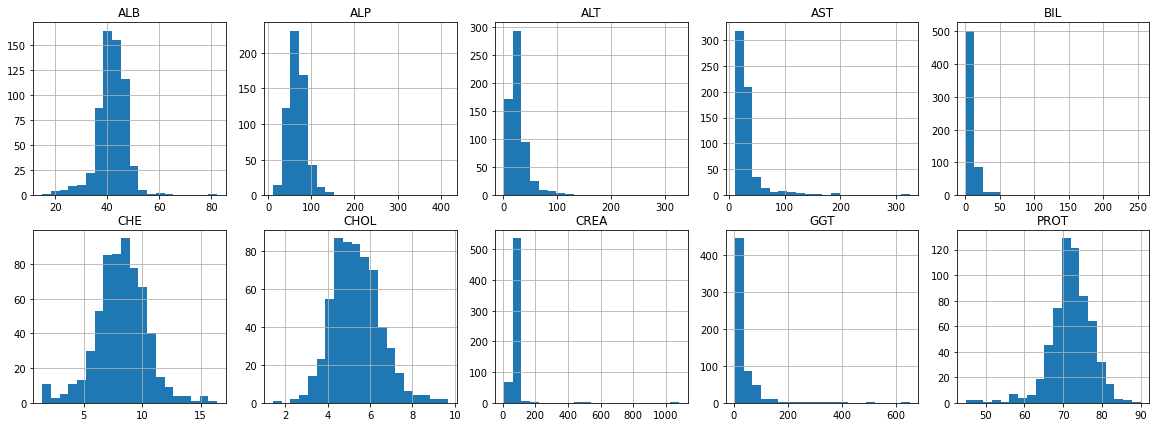

In [339]:
fig, axs = plt.subplots(2, 5, figsize=(20,7))
i=0
j=0

for column in data.columns[3:]:
    if i<5:
        data[column].hist(ax=axs[j][i],bins=20)
        axs[j][i].set_title(column)
        i+=1
    else:
        j+=1 
        i=0
        data[column].hist(ax=axs[j][i],bins=20)
        axs[j][i].set_title(column)
        i+=1

Заменим пропуски медианным значением по каждой категории

In [340]:
for column in data.columns[3:]:
    data[column]=data[column].fillna(data[column].median())

In [341]:
data.isna().sum()

Category    0
Age         0
Sex         0
ALB         0
ALP         0
ALT         0
AST         0
BIL         0
CHE         0
CHOL        0
CREA        0
GGT         0
PROT        0
dtype: int64

### 2.3 Проверка мультиколлинеарности

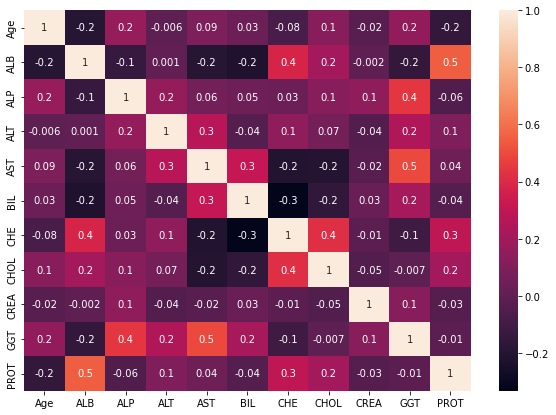

In [342]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10,7))

sns.heatmap(data.corr(), annot=True, fmt='.1g')
plt.show()

Между некоторыми величинами есть наблюдается средняя корреляция, что означает мультиколлинеарность этих величин. Однако, удалять я их не буду, т.к. связь недостаточно сильная

### 2.4 Проверка сбалансированности классов

In [343]:
print(data['Category'].value_counts())

0=Blood Donor             533
3=Cirrhosis                30
1=Hepatitis                24
2=Fibrosis                 21
0s=suspect Blood Donor      7
Name: Category, dtype: int64


Представленные классы не являются сбалансированными, что означает, что для обучения модели такие данные подходят не очень хорошо в сыром виде. Я планирую использовать взвешенную функцию потерь для минимизации дисбаланса в сочетании со стратифицированными выборками.

### 2.5 Кодирование признаков

Закодируем категориальный признак Sex, а также целевой признак.

In [344]:
from sklearn.preprocessing import LabelEncoder
target= LabelEncoder().fit_transform(data['Category'].values)
target= np.array(target)

In [345]:
sex_data = pd.get_dummies(data['Sex'])
data[sex_data.columns]=sex_data 
data=data.drop(columns=["Category","Sex"])

data.head()

,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,f,m
0,32,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0,0,1
1,32,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5,0,1
2,32,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3,0,1
3,32,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7,0,1
4,32,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7,0,1


### 2.6 Рассчет весов классов

In [346]:
weights=[]
for x in np.unique(target,axis = 0):
    weights.append(1-(np.sum(target==x)/target.shape[0]))
class_weights=torch.FloatTensor(weights)

<div style="border:solid #4F6272 1px; padding: 4px">


    По итогу раздела был осуществлен обзор датафрейма, произведена проверка на пропуски, на наличие дубликатов,  признаки проверены на мультиколлинеарность. Проверка данных на выбросы не осуществлялась, т.к. вменяемость значений признаков должна быть оценена экспертами. Проверена сбалансированность классов. Рассчитаны веса каждого из классов для функции потерь.

## 3. Разработка модели классификации

###  3.1. Использование SKFold для кросс-валидации

In [347]:
features = data
scaler = StandardScaler()    
scaled_features=scaler.fit_transform(features) 

In [348]:
skf = StratifiedKFold(n_splits=5,random_state=13, shuffle=True)

In [349]:
scaled_features=torch.tensor(scaled_features)
target=torch.tensor(target.astype("long"))

In [350]:
LR = 1e-3
N_EPOCH = 1300
DROP_PROB=0.3

In [351]:
def train(model, scaled_features, target,loss_function, optimizer):
    epoch_score_train=[]
    epoch_score_test=[]
    for epoch in tqdm(range(1, N_EPOCH+1)):
        score_list=[]
        score_test=[]
        for i, (train_index, test_index) in enumerate(skf.split(scaled_features, target)):
            train_features=scaled_features[train_index]
            train_target=target[train_index]
            
            test_features=scaled_features[test_index]
            test_target=target[test_index]
            
            model.train()
            train_predictions = model(train_features.float())
            loss = loss_function(train_predictions, train_target.long())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            class_list=[]
            for i in train_predictions:
                class_list.append(np.argmax(i.detach().numpy()))
            score_list.append(f1_score(train_target,class_list,average='micro'))
            
            with torch.no_grad():
                test_predictions = model(test_features.float())
                test_class=[]
                for i in test_predictions:
                    test_class.append(np.argmax(i.detach().numpy()))
                score_test.append(f1_score(test_target,test_class,average='micro'))
        train_f1=np.mean(score_list)
        test_f1=np.mean(score_test)
        epoch_score_train.append(train_f1)
        epoch_score_test.append(test_f1)
        if epoch % 50 == 0:
            print('Epoch : {:3d} / {}, Train_f1 : {:.2f}, Test_f1 : {:.2f}'.format(
            epoch, N_EPOCH, train_f1, test_f1))
    return epoch_score_train, epoch_score_test

###  3.2. НC с использованиеми дроп-аут c оптимизатором Adam

In [352]:
loss_function=torch.nn.CrossEntropyLoss(weight = class_weights)

In [353]:
class DNN_1(nn.Module):
    def __init__(self, DROP_PROB=0.3):
        super(DNN_1, self).__init__()
        
        self.fc1 = nn.Linear(13, 8)
        self.fc2 = nn.Linear(8, 5)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=DROP_PROB)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [354]:
model=DNN_1(DROP_PROB)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [355]:
train_list, test_list = train(model, scaled_features, target, loss_function, optimizer)

  0%|          | 0/1300 [00:00<?, ?it/s]

Epoch :  50 / 1300, Train_f1 : 0.47, Test_f1 : 0.47
Epoch : 100 / 1300, Train_f1 : 0.67, Test_f1 : 0.68
Epoch : 150 / 1300, Train_f1 : 0.79, Test_f1 : 0.79
Epoch : 200 / 1300, Train_f1 : 0.84, Test_f1 : 0.85
Epoch : 250 / 1300, Train_f1 : 0.85, Test_f1 : 0.85
Epoch : 300 / 1300, Train_f1 : 0.87, Test_f1 : 0.87
Epoch : 350 / 1300, Train_f1 : 0.89, Test_f1 : 0.88
Epoch : 400 / 1300, Train_f1 : 0.88, Test_f1 : 0.90
Epoch : 450 / 1300, Train_f1 : 0.89, Test_f1 : 0.89
Epoch : 500 / 1300, Train_f1 : 0.88, Test_f1 : 0.89
Epoch : 550 / 1300, Train_f1 : 0.88, Test_f1 : 0.89
Epoch : 600 / 1300, Train_f1 : 0.89, Test_f1 : 0.89
Epoch : 650 / 1300, Train_f1 : 0.90, Test_f1 : 0.89
Epoch : 700 / 1300, Train_f1 : 0.90, Test_f1 : 0.91
Epoch : 750 / 1300, Train_f1 : 0.91, Test_f1 : 0.90
Epoch : 800 / 1300, Train_f1 : 0.90, Test_f1 : 0.89
Epoch : 850 / 1300, Train_f1 : 0.90, Test_f1 : 0.89
Epoch : 900 / 1300, Train_f1 : 0.91, Test_f1 : 0.91
Epoch : 950 / 1300, Train_f1 : 0.90, Test_f1 : 0.91
Epoch : 1000

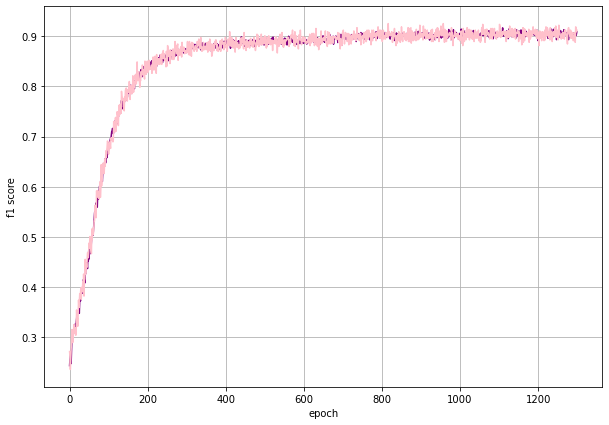

In [358]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10,7))
axes.plot(range(len(train_list)),train_list,color='purple')
axes.plot(range(len(test_list)),test_list,color="pink")
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('f1 score')
plt.show()

###  3.3. НC без дроп-аут с оптимизатором Rprop

In [359]:
N_EPOCH = 300

In [360]:
loss_function=torch.nn.CrossEntropyLoss(weight = class_weights)

In [361]:
class DNN_2(nn.Module):
    def __init__(self):
        super(DNN_2, self).__init__()
        
        self.fc1 = nn.Linear(features.shape[1], 8)
        self.fc2 = nn.Linear(8, 5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [362]:
model=DNN_2()
optimizer = torch.optim.Rprop(model.parameters(), lr=0.0001)

In [363]:
train_list, test_list=train(model, scaled_features, target, loss_function, optimizer)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch :  50 / 300, Train_f1 : 0.98, Test_f1 : 0.98
Epoch : 100 / 300, Train_f1 : 0.97, Test_f1 : 0.97
Epoch : 150 / 300, Train_f1 : 0.97, Test_f1 : 0.97
Epoch : 200 / 300, Train_f1 : 0.97, Test_f1 : 0.97
Epoch : 250 / 300, Train_f1 : 0.97, Test_f1 : 0.97
Epoch : 300 / 300, Train_f1 : 0.97, Test_f1 : 0.97


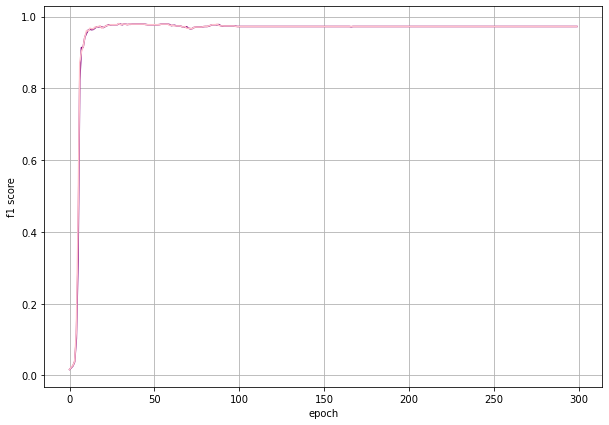

In [364]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10,7))
axes.plot(range(len(train_list)),train_list,color='purple')
axes.plot(range(len(test_list)),test_list,color="pink")
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('f1 score')
plt.show()

## 4. Проверка оптимальности моделей классификации

###  4.1. Подбор гиперпараметров НC с использованиеми дроп-аут c оптимизатором Adam

In [365]:
params_grid = ParameterGrid({'p':[0.3,0.5,0.7],'lr': [0.001,0.01,0.1]})
loss_function=torch.nn.CrossEntropyLoss(weight = class_weights)

In [366]:
f1_scores=[]
for param in tqdm(params_grid):
    print('\nparameters configuration:',param)
    model=DNN_1(DROP_PROB=param['p'])
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=param['lr'])
    train(model, scaled_features, target, loss_function, optimizer)

  0%|          | 0/9 [00:00<?, ?it/s]


parameters configuration: {'lr': 0.001, 'p': 0.3}


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch :  50 / 300, Train_f1 : 0.77, Test_f1 : 0.77
Epoch : 100 / 300, Train_f1 : 0.87, Test_f1 : 0.87
Epoch : 150 / 300, Train_f1 : 0.88, Test_f1 : 0.87
Epoch : 200 / 300, Train_f1 : 0.88, Test_f1 : 0.89
Epoch : 250 / 300, Train_f1 : 0.90, Test_f1 : 0.90
Epoch : 300 / 300, Train_f1 : 0.89, Test_f1 : 0.90

parameters configuration: {'lr': 0.001, 'p': 0.5}


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch :  50 / 300, Train_f1 : 0.87, Test_f1 : 0.89
Epoch : 100 / 300, Train_f1 : 0.90, Test_f1 : 0.90
Epoch : 150 / 300, Train_f1 : 0.91, Test_f1 : 0.90
Epoch : 200 / 300, Train_f1 : 0.90, Test_f1 : 0.90
Epoch : 250 / 300, Train_f1 : 0.90, Test_f1 : 0.91
Epoch : 300 / 300, Train_f1 : 0.91, Test_f1 : 0.89

parameters configuration: {'lr': 0.001, 'p': 0.7}


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch :  50 / 300, Train_f1 : 0.71, Test_f1 : 0.72
Epoch : 100 / 300, Train_f1 : 0.88, Test_f1 : 0.87
Epoch : 150 / 300, Train_f1 : 0.88, Test_f1 : 0.88
Epoch : 200 / 300, Train_f1 : 0.88, Test_f1 : 0.88
Epoch : 250 / 300, Train_f1 : 0.88, Test_f1 : 0.86
Epoch : 300 / 300, Train_f1 : 0.88, Test_f1 : 0.86

parameters configuration: {'lr': 0.01, 'p': 0.3}


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch :  50 / 300, Train_f1 : 0.93, Test_f1 : 0.93
Epoch : 100 / 300, Train_f1 : 0.92, Test_f1 : 0.92
Epoch : 150 / 300, Train_f1 : 0.92, Test_f1 : 0.94
Epoch : 200 / 300, Train_f1 : 0.92, Test_f1 : 0.90
Epoch : 250 / 300, Train_f1 : 0.92, Test_f1 : 0.93
Epoch : 300 / 300, Train_f1 : 0.91, Test_f1 : 0.90

parameters configuration: {'lr': 0.01, 'p': 0.5}


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch :  50 / 300, Train_f1 : 0.85, Test_f1 : 0.86
Epoch : 100 / 300, Train_f1 : 0.86, Test_f1 : 0.83
Epoch : 150 / 300, Train_f1 : 0.83, Test_f1 : 0.84
Epoch : 200 / 300, Train_f1 : 0.85, Test_f1 : 0.85
Epoch : 250 / 300, Train_f1 : 0.83, Test_f1 : 0.85
Epoch : 300 / 300, Train_f1 : 0.85, Test_f1 : 0.84

parameters configuration: {'lr': 0.01, 'p': 0.7}


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch :  50 / 300, Train_f1 : 0.89, Test_f1 : 0.89
Epoch : 100 / 300, Train_f1 : 0.90, Test_f1 : 0.89
Epoch : 150 / 300, Train_f1 : 0.90, Test_f1 : 0.89
Epoch : 200 / 300, Train_f1 : 0.90, Test_f1 : 0.90
Epoch : 250 / 300, Train_f1 : 0.90, Test_f1 : 0.92
Epoch : 300 / 300, Train_f1 : 0.91, Test_f1 : 0.90

parameters configuration: {'lr': 0.1, 'p': 0.3}


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch :  50 / 300, Train_f1 : 0.91, Test_f1 : 0.91
Epoch : 100 / 300, Train_f1 : 0.94, Test_f1 : 0.92
Epoch : 150 / 300, Train_f1 : 0.91, Test_f1 : 0.90
Epoch : 200 / 300, Train_f1 : 0.92, Test_f1 : 0.91
Epoch : 250 / 300, Train_f1 : 0.90, Test_f1 : 0.91
Epoch : 300 / 300, Train_f1 : 0.85, Test_f1 : 0.87

parameters configuration: {'lr': 0.1, 'p': 0.5}


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch :  50 / 300, Train_f1 : 0.81, Test_f1 : 0.81
Epoch : 100 / 300, Train_f1 : 0.84, Test_f1 : 0.85
Epoch : 150 / 300, Train_f1 : 0.82, Test_f1 : 0.82
Epoch : 200 / 300, Train_f1 : 0.85, Test_f1 : 0.83
Epoch : 250 / 300, Train_f1 : 0.85, Test_f1 : 0.84
Epoch : 300 / 300, Train_f1 : 0.84, Test_f1 : 0.84

parameters configuration: {'lr': 0.1, 'p': 0.7}


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch :  50 / 300, Train_f1 : 0.89, Test_f1 : 0.90
Epoch : 100 / 300, Train_f1 : 0.89, Test_f1 : 0.89
Epoch : 150 / 300, Train_f1 : 0.89, Test_f1 : 0.88
Epoch : 200 / 300, Train_f1 : 0.89, Test_f1 : 0.89
Epoch : 250 / 300, Train_f1 : 0.89, Test_f1 : 0.90
Epoch : 300 / 300, Train_f1 : 0.89, Test_f1 : 0.89


###  4.2. Оптимизация гиперпараметров НC без дроп-аут с оптимизатором Rprop

In [367]:
params_grid=ParameterGrid({'lr': [0.0001,0.001,0.01,0.1]})

In [368]:
for param in tqdm(params_grid):
    print('\nparameters configuration:',param)
    model=DNN_2()
    model.train()
    optimizer = torch.optim.Rprop(model.parameters(), lr=param['lr'])
    train(model, scaled_features, target, loss_function, optimizer)

  0%|          | 0/4 [00:00<?, ?it/s]


parameters configuration: {'lr': 0.0001}


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch :  50 / 300, Train_f1 : 0.98, Test_f1 : 0.98
Epoch : 100 / 300, Train_f1 : 0.97, Test_f1 : 0.97
Epoch : 150 / 300, Train_f1 : 0.97, Test_f1 : 0.97
Epoch : 200 / 300, Train_f1 : 0.97, Test_f1 : 0.97
Epoch : 250 / 300, Train_f1 : 0.97, Test_f1 : 0.97
Epoch : 300 / 300, Train_f1 : 0.97, Test_f1 : 0.97

parameters configuration: {'lr': 0.001}


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch :  50 / 300, Train_f1 : 0.97, Test_f1 : 0.97
Epoch : 100 / 300, Train_f1 : 0.97, Test_f1 : 0.97
Epoch : 150 / 300, Train_f1 : 0.98, Test_f1 : 0.98
Epoch : 200 / 300, Train_f1 : 0.98, Test_f1 : 0.98
Epoch : 250 / 300, Train_f1 : 0.99, Test_f1 : 0.99
Epoch : 300 / 300, Train_f1 : 0.99, Test_f1 : 0.99

parameters configuration: {'lr': 0.01}


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch :  50 / 300, Train_f1 : 0.98, Test_f1 : 0.98
Epoch : 100 / 300, Train_f1 : 0.98, Test_f1 : 0.98
Epoch : 150 / 300, Train_f1 : 0.98, Test_f1 : 0.98
Epoch : 200 / 300, Train_f1 : 0.98, Test_f1 : 0.98
Epoch : 250 / 300, Train_f1 : 0.98, Test_f1 : 0.98
Epoch : 300 / 300, Train_f1 : 0.98, Test_f1 : 0.98

parameters configuration: {'lr': 0.1}


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch :  50 / 300, Train_f1 : 0.98, Test_f1 : 0.98
Epoch : 100 / 300, Train_f1 : 0.98, Test_f1 : 0.98
Epoch : 150 / 300, Train_f1 : 0.98, Test_f1 : 0.98
Epoch : 200 / 300, Train_f1 : 0.98, Test_f1 : 0.98
Epoch : 250 / 300, Train_f1 : 0.98, Test_f1 : 0.98
Epoch : 300 / 300, Train_f1 : 0.98, Test_f1 : 0.98


## 4. Выводы

<div style="border:solid #8A2BE2 2px; padding: 40px">
    
Задачей исследования было построение модели  классификации поражения печени у пациентов по лабораторным и нелабораторным признакам.
В ходе исследования были изучены предоставленные данные, произведена предобработка данных, включая проверку на пропуски, мультиколлинеарность, дубликаты,а также маштабирование признаков.

Рассматриваемые данные обладали рядом недостатков, среди которых несбалансированность классов (объектов остальных классов меньше в 6,5 раз, чем объектов лидирующего класса), малый объем самих данных, а также наличие пропусков  в классах с малым количеством объектов. В ходе работы было принято решение о применении SKfold в сочетании со взвешенной функцией потерь. Веса каждого из классов были расчитаны с учетом количества представителей данного класса в рассматриваемой выборке.
    
Были рассмотрены две двухслойные нейронные сети: с использованием дроп-аут и без использования. В качестве оптимизаторов был выбран Adam и Rprop, в качестве метрики использовалась f1_score. В качестве функции потерь использовалась функция Кросс-энтропии.

Первая модель показала результат метрики, равный
* f1 на валидационной выборке: **0.9**
    
Вторая модель показала результат метрики, равный
* f1 на валидационной выборке: **0.98**    

__________________________
Рекомендации: Для улучшения работы модели имеет смысл оценить выбросы в признаках с точки зрения здравого смысла, проверить нет ли в данных аномальных значений, а также дополнить данные для увеличения выборки.